In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        sparsity["ann_score"] = sparsity.pop("score", None)
        return dict(
            task=task,
            **sparsity,
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def technique(s: pd.Series) -> str:
    return "_".join(str(n) for n in [s["name"], s["strategy"], s["ann_score"]] if not pd.isna(n))

df = (
    load_sweep("RMOE-58-ann-local")
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    .pipe(lambda d: d.assign(technique=d.apply(technique, axis=1)))
    .pipe(lambda d: d.assign(local_ratio=d.apply(lambda s: s.local_k / s.k, axis=1)))
)
df.head()

,task,k,name,local_k,strategy,ann_score,match,rougeL,rank,score,technique,local_ratio
0,cnn_dailymail,256,eviction,128,lru,None,NaN,0.161848,NaN,0.161848,eviction_lru,0.50
1,cnn_dailymail,256,eviction,64,lru,None,NaN,0.162358,NaN,0.162358,eviction_lru,0.25
2,cnn_dailymail,256,eviction,0,lru,None,NaN,0.159028,NaN,0.159028,eviction_lru,0.00
3,cnn_dailymail,256,eviction,192,sum_weight,None,NaN,0.178955,NaN,0.178955,eviction_sum_weight,0.75
4,cnn_dailymail,256,eviction,128,sum_weight,None,NaN,0.189260,NaN,0.189260,eviction_sum_weight,0.50


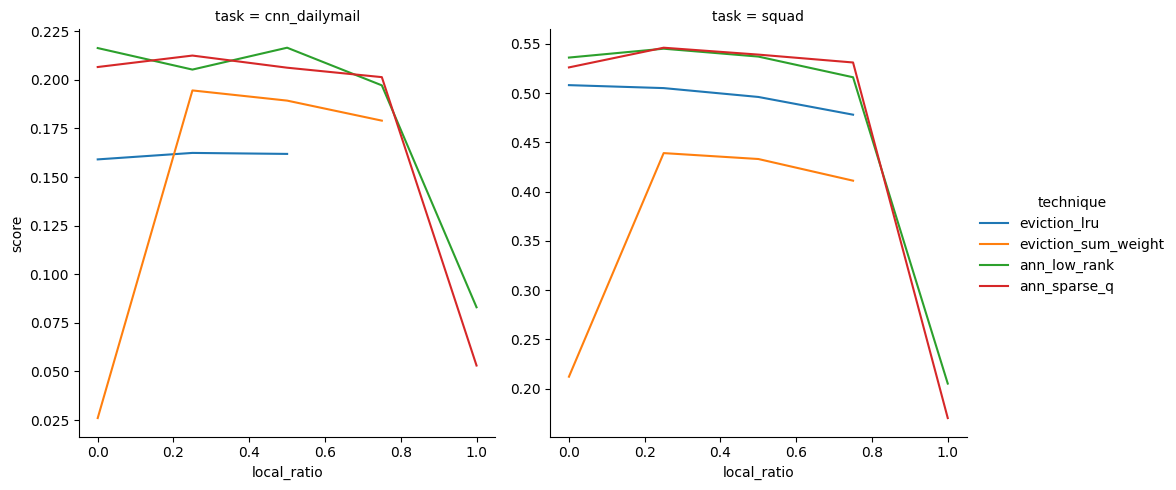

In [3]:
sns.relplot(data=df, y="score", x="local_ratio", hue="technique", col="task", kind="line", facet_kws=dict(sharey=False));